# Results analysis

You can use this notebook to analyze the results of your training runs on Cori.

In [1]:
# System
import os
import re

# Externals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Magic
%matplotlib inline

## Gather results

Find all of the results in our results directory and build a DataFrame.

In [3]:
def parse_log(log_file):
    avg_epoch_time = None
    with open(log_file) as f:
        time_pattern = re.compile('.* Average time per epoch: (\S+) s')
        #acc_pattern = re.compile('.* Best validation accuracy: (\S+)')
        for l in f:
            tm = time_pattern.match(l.strip())
            if tm is not None:
                avg_epoch_time = float(tm.group(1))
    return avg_epoch_time

def parse_one_result(rdir):
    """Returns a dict of all data from one training result"""
    log_file = os.path.join(rdir, 'out.log')
    result_name = os.path.basename(rdir)
    n_nodes = int(re.match('.*-N(.*)-.*', result_name).group(1))
    avg_epoch_time = parse_log(log_file)
    history = np.load(os.path.join(rdir, 'history.npz'))
    return dict(result_name=result_name, n_nodes=n_nodes,
                avg_epoch_time=avg_epoch_time, history=history)

def parse_results(results_dirs):
    results = [pd.Series(data=parse_one_result(rdir)) for rdir in results_dirs]  
    return pd.DataFrame(data=results).sort_values(by='n_nodes').reset_index(drop=True)

In [4]:
results_dir = os.path.join(os.environ['SCRATCH'], 'ecp19-dl-tutorial')
result_prefix = 'cifar10-resnet'
results_dirs = [
    os.path.join(results_dir, rdir)
    for rdir in os.listdir(results_dir)
    if rdir.startswith(result_prefix)
]

results = parse_results(results_dirs)

In [5]:
results

,result_name,n_nodes,avg_epoch_time,history
0,cifar10-resnet-N1-17641093,1,155.820,"(n_ranks, val_loss, val_acc, loss, acc, lr)"
1,cifar10-resnet-N2-17673733,2,91.241,"(n_ranks, val_loss, val_acc, loss, acc, lr)"
2,cifar10-resnet-N4-17635783,4,51.802,"(n_ranks, val_loss, val_acc, loss, acc, lr)"
3,cifar10-resnet-N8-17679346,8,30.571,"(n_ranks, val_loss, val_acc, loss, acc, lr)"
4,cifar10-resnet-N16-17680685,16,20.141,"(n_ranks, val_loss, val_acc, loss, acc, lr)"
5,cifar10-resnet-N32-17680696,32,15.607,"(n_ranks, val_loss, val_acc, loss, acc, lr)"


## Plot Epoch time

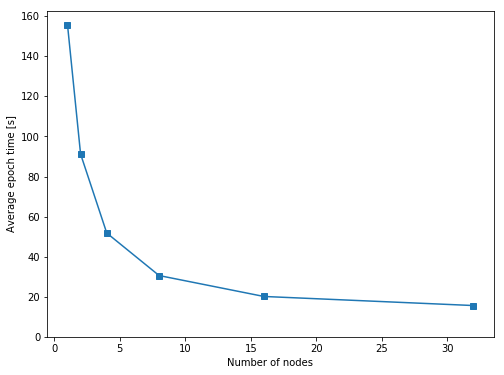

In [6]:
plt.figure(figsize=(8,6))

plt.plot(results.n_nodes, results.avg_epoch_time, 's-')
plt.xlabel('Number of nodes')
plt.ylabel('Average epoch time [s]')
plt.ylim(bottom=0);

In [8]:
results.avg_epoch_time

0    155.820
1     91.241
2     51.802
3     30.571
4     20.141
5     15.607
Name: avg_epoch_time, dtype: float64

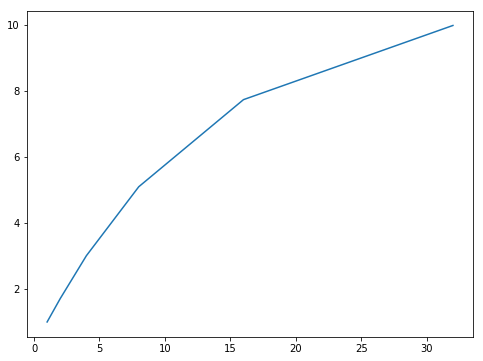

In [12]:
plt.figure(figsize=(8, 6))
speedup = results.avg_epoch_time[0] / results.avg_epoch_time
plt.plot(results.n_nodes, speedup)

## Plot training curves

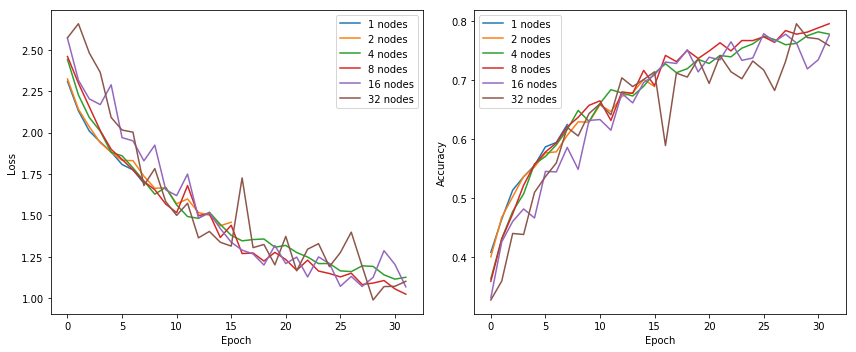

In [7]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,5))

# Loop over results
for i, row in results.iterrows():
    label = '%i nodes' % row.n_nodes
    ax0.plot(row.history['val_loss'], label=label)
    ax0.set_xlabel('Epoch')
    ax0.set_ylabel('Loss')
    ax0.legend(loc=0)
    
    ax1.plot(row.history['val_acc'], label=label)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc=0)

plt.tight_layout()